# **Introduction**
The goal of this project is to predict the dividends issued by stocks in the S&P 500; this will be accomplished with a neural network that that takes input from the stock's filed financial forms.  Specifically, for a particular stock each input of the neural network is the number of divideds issued in a calendar year; this was train then tested with a 80%-20% split of the S&P 500 stocks.  While the initial analysis was not very accurate, hidden layers were added to the model to account for any non-linear pattern that might exist within the dividend data.

# **Data Curation**

Import the necessary libraries

In [109]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import json
import numpy as np
import time
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

Store the necessary URLs as constants

In [110]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sec_url = 'https://www.sec.gov/files/company_tickers.json'
cik_url = 'https://www.sec.gov/Archives/edgar/cik-lookup-data.txt'

Get the symbols from Wikipedia

In [111]:
r = requests.get(wiki_url)
print(r)

<Response [200]>


Parse the HTML response from Wikipedia

In [112]:
root = bs(r.content, "html")
table = pd.read_html(root.find('table').prettify())[0]
table.head()

/tmp/ipython-input-112-1283966118.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(root.find('table').prettify())[0]


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee , Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin , Ireland",2011-07-06,1467373,1989


Parse out the specific ticker symbols and corresponding CIKs from the table

In [113]:
tickers = table["Symbol"]
tickers

,Symbol
0,MMM
1,AOS
2,ABT
3,ABBV
4,ACN
...,...
498,XYL
499,YUM
500,ZBRA
501,ZBH


In [114]:
ciks = [str(i).rjust(10, '0') for i in table["CIK"]]
print(ciks)
ciks = pd.Series(ciks)
ciks

['0000066740', '0000091142', '0000001800', '0001551152', '0001467373', '0000796343', '0000002488', '0000874761', '0000004977', '0001090872', '0000002969', '0001559720', '0001086222', '0000915913', '0001035443', '0001097149', '0001579241', '0000352541', '0000899051', '0001652044', '0001652044', '0000764180', '0001018724', '0001748790', '0001002910', '0000004904', '0000004962', '0000005272', '0001053507', '0001410636', '0000820027', '0001037868', '0000318154', '0000820313', '0000006281', '0001013462', '0000315293', '0001841666', '0001858681', '0000320193', '0000006951', '0001521332', '0000947484', '0000007084', '0001596532', '0000354190', '0001267238', '0000732717', '0000731802', '0000769397', '0000008670', '0000866787', '0000915912', '0000008818', '0001069183', '0001701605', '0000009389', '0000070858', '0000010456', '0000010795', '0001067983', '0000764478', '0000842023', '0000875045', '0002012383', '0001393818', '0001390777', '0000012927', '0001075531', '0000885725', '0000014272', '0001

,0
0,0000066740
1,0000091142
2,0000001800
3,0001551152
4,0001467373
...,...
498,0001524472
499,0001041061
500,0000877212
501,0001136869


Add both the tickers and CIKs to the dataframe

In [115]:
df = pd.DataFrame(tickers)
df["ciks"] = ciks
print(df)

    Symbol        ciks
0      MMM  0000066740
1      AOS  0000091142
2      ABT  0000001800
3     ABBV  0001551152
4      ACN  0001467373
..     ...         ...
498    XYL  0001524472
499    YUM  0001041061
500   ZBRA  0000877212
501    ZBH  0001136869
502    ZTS  0001555280

[503 rows x 2 columns]


Get dividend history for each CIK

In [106]:
header = {
    "User-Agent": "scheruvu@umd.edu"
}

indiv_files = []
symbols = []
int_gotten = 0
curr = 0

#for thing in df.values[::10]:
#  address = "https://data.sec.gov/api/xbrl/companyfacts/CIK" + thing[1] + ".json"
  #print(address)
#  response = requests.get(address, headers=header).json()
#  try:
#      indiv_files.append(response["facts"]["us-gaap"]["CommonStockDividendsPerShareCashPaid"]["units"]["USD/shares"])
#  except:
#      indiv_files.append("N/A")

while int_gotten < 50:
  address = "https://data.sec.gov/api/xbrl/companyfacts/CIK" + df.values[curr][1] + ".json"
  response = requests.get(address, headers=header).json()
  try:
      indiv_files.append(response["facts"]["us-gaap"]["CommonStockDividendsPerShareCashPaid"]["units"]["USD/shares"])
      symbols.append(df[df["ciks"] == df.values[curr][1]]["Symbol"].values[0])
      int_gotten += 1
      curr += 1
  except:
      curr += 1


Get start date, end date, and per-share value

In [107]:
#date_stamps = indiv_files[0][0]['val']
#date_stamps = [[j['start'], j['end'], j['val']] for j in indiv_files[0]]
date_stamps = [[[j['start'], j['end'], j['val']] for j in i if ("-12-31" in j['end']) and ("-01-01" in j['start']) and ("frame" in j.keys()) and (j['frame'] == "CY" + j['end'][:4])] for i in indiv_files]
date_stamps

[[['2007-01-01', '2007-12-31', 1.92],
  ['2008-01-01', '2008-12-31', 2],
  ['2009-01-01', '2009-12-31', 2.04],
  ['2012-01-01', '2012-12-31', 2.36],
  ['2013-01-01', '2013-12-31', 2.54],
  ['2014-01-01', '2014-12-31', 3.42],
  ['2015-01-01', '2015-12-31', 4.1],
  ['2016-01-01', '2016-12-31', 4.44],
  ['2017-01-01', '2017-12-31', 4.7]],
 [['2009-01-01', '2009-12-31', 0.51],
  ['2010-01-01', '2010-12-31', 0.54],
  ['2011-01-01', '2011-12-31', 0.3],
  ['2012-01-01', '2012-12-31', 0.36],
  ['2013-01-01', '2013-12-31', 0.46],
  ['2014-01-01', '2014-12-31', 0.3],
  ['2015-01-01', '2015-12-31', 0.38],
  ['2016-01-01', '2016-12-31', 0.48],
  ['2017-01-01', '2017-12-31', 0.56],
  ['2018-01-01', '2018-12-31', 0.76],
  ['2019-01-01', '2019-12-31', 0.9],
  ['2020-01-01', '2020-12-31', 0.98],
  ['2021-01-01', '2021-12-31', 1.06],
  ['2022-01-01', '2022-12-31', 1.14],
  ['2023-01-01', '2023-12-31', 1.22]],
 [['2016-01-01', '2016-12-31', 2.35],
  ['2017-01-01', '2017-12-31', 2.63],
  ['2018-01-01', '

Create pandas DataFrame

In [108]:
to_transform = []

for x in range(len(date_stamps)):
  for y in range(len(date_stamps[x])):
    to_transform.append(date_stamps[x][y] + [symbols[x]])

to_transform = np.array(to_transform)
final_df = pd.DataFrame({"Start": to_transform[:, 0], "End": to_transform[:, 1], "Value": to_transform[:, 2], "Symbol": to_transform[:, 3]})

final_df

,Start,End,Value,Symbol
0,2007-01-01,2007-12-31,1.92,MMM
1,2008-01-01,2008-12-31,2,MMM
2,2009-01-01,2009-12-31,2.04,MMM
3,2012-01-01,2012-12-31,2.36,MMM
4,2013-01-01,2013-12-31,2.54,MMM
...,...,...,...,...
285,2020-01-01,2020-12-31,0.96,CHD
286,2021-01-01,2021-12-31,1.01,CHD
287,2022-01-01,2022-12-31,1.05,CHD
288,2023-01-01,2023-12-31,1.09,CHD


# **Exploratory Data Analysis**

Hypothesis 1: The 50 stocks we selected from the S&P 500 have issued more dividends than the mean as compared to the stocks we did not select for analysisax1.set_xlabel("Z-score") **bold text**

Filter out the S&P 500 ciks we have not selected

In [116]:
non_sp500_ciks_isin = ~df['Symbol'].isin(symbols)
non_sp500_df = df[['Symbol','ciks']][non_sp500_ciks_isin]
display(non_sp500_df)
#generate the S&P 500 mean
#run z-test

,Symbol,ciks
2,ABT,0000001800
5,ADBE,0000796343
6,AMD,0000002488
10,APD,0000002969
11,ABNB,0001559720
...,...,...
498,XYL,0001524472
499,YUM,0001041061
500,ZBRA,0000877212
501,ZBH,0001136869


Get 500 non-S&P 500 filings at random

In [117]:
indiv_files_non_sp_500 = []
symbols_non_sp_500 = []
int_gotten = 0
curr = 0
non_sp500_ciks_length = non_sp500_df['Symbol'].size

#for thing in df.values[::10]:
#  address = "https://data.sec.gov/api/xbrl/companyfacts/CIK" + thing[1] + ".json"
  #print(address)
#  response = requests.get(address, headers=header).json()
#  try:
#      indiv_files.append(response["facts"]["us-gaap"]["CommonStockDividendsPerShareCashPaid"]["units"]["USD/shares"])
#  except:
#      indiv_files.append("N/A")

while int_gotten < 50:
  print(str(int_gotten) + "/50")
  address = "https://data.sec.gov/api/xbrl/companyfacts/CIK" + non_sp500_df.values[curr][1] + ".json"
  response = requests.get(address, headers=header).json()
  time.sleep(0.1)
  try:
      indiv_files_non_sp_500.append(response["facts"]["us-gaap"]["CommonStockDividendsPerShareCashPaid"]["units"]["USD/shares"])
      symbols_non_sp_500.append(df[df["ciks"] == non_sp500_df.values[curr][1]]["Symbol"].values[0])
      int_gotten += 1
      curr += 1
  except:
      curr += 1

0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
0/50
1/50
2/50
2/50
3/50
4/50
5/50
5/50
6/50
7/50
7/50
7/50
7/50
8/50
9/50
10/50
10/50
10/50
11/50
11/50
12/50
12/50
12/50
12/50
13/50
14/50
14/50
15/50
16/50
17/50
18/50
18/50
19/50
19/50
19/50
19/50
19/50
20/50
21/50
21/50
22/50
22/50
23/50
23/50
24/50
24/50
25/50
26/50
26/50
27/50
28/50
29/50
29/50
29/50
30/50
30/50
31/50
31/50
31/50
31/50
31/50
32/50
33/50
34/50
34/50
34/50
35/50
35/50
36/50
37/50
38/50
38/50
38/50
39/50
40/50
40/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
47/50
48/50
49/50


Create non selected dataframe



In [118]:
non_sp500_df = pd.DataFrame({'symbols':symbols_non_sp_500,'dividends':indiv_files_non_sp_500})
non_sp500_df['sum'] = non_sp500_df['dividends'].apply(lambda d: len(d))
non_sp500_df

,symbols,dividends,sum
0,CTAS,"[{'start': '2008-06-01', 'end': '2009-05-31', ...",8
1,CSCO,"[{'start': '2011-03-01', 'end': '2011-03-17', ...",177
2,CFG,"[{'start': '2012-01-01', 'end': '2012-12-31', ...",63
3,CLX,"[{'start': '2008-07-01', 'end': '2009-06-30', ...",45
4,CME,"[{'start': '2007-01-01', 'end': '2007-12-31', ...",131
5,KO,"[{'start': '2007-01-01', 'end': '2007-12-31', ...",82
6,CTSH,"[{'start': '2017-04-01', 'end': '2017-06-30', ...",21
7,CAG,"[{'start': '2009-06-01', 'end': '2009-08-30', ...",82
8,COP,"[{'start': '2008-01-01', 'end': '2008-06-30', ...",167
9,ED,"[{'start': '2016-01-01', 'end': '2016-12-31', ...",92


Create selected dataframe

In [119]:
sp500_df = pd.DataFrame({'symbols':symbols,'dividends':indiv_files})
sp500_df['sum'] = sp500_df['dividends'].apply(lambda d: len(d))
sp500_df

,symbols,dividends,sum
0,MMM,"[{'start': '2007-01-01', 'end': '2007-12-31', ...",156
1,AOS,"[{'start': '2009-01-01', 'end': '2009-06-30', ...",188
2,ABBV,"[{'end': '2015-02-19', 'val': 0.51, 'accn': '0...",57
3,ACN,"[{'start': '2007-09-01', 'end': '2008-08-31', ...",228
4,AES,"[{'start': '2013-01-01', 'end': '2013-03-31', ...",119
5,AFL,"[{'start': '2009-01-01', 'end': '2009-03-31', ...",164
6,A,"[{'start': '2011-11-01', 'end': '2012-01-31', ...",129
7,ALLE,"[{'start': '2018-01-01', 'end': '2018-12-31', ...",77
8,LNT,"[{'start': '2008-01-01', 'end': '2008-12-31', ...",45
9,ALL,"[{'start': '2008-01-01', 'end': '2008-12-31', ...",12


Create a z-score then bin the z-score for both the selected and non selected

In [120]:
non_sp500_df['z-score'] = non_sp500_df['sum'].apply(lambda s: (s - non_sp500_df['sum'].mean())/non_sp500_df['sum'].std())
sp500_df['z-score'] = sp500_df['sum'].apply(lambda s: (s - sp500_df['sum'].mean())/sp500_df['sum'].std())
def bin_z_score(z):
  if z < -3.0:
    return '-3.5'
  elif z >= -3.0 and z < -2.5:
    return '-3.0'
  elif z >= -2.5 and z < -2.0:
    return '-2.5'
  elif z >= -2.0 and z < -1.5:
    return '-2.0'
  elif z >= -1.5 and z < -1.0:
    return '-1.5'
  elif z >= -1.0 and z < -0.5:
    return '-1.0'
  elif z >= -0.5 and z < 0:
    return '-0.5'
  elif z >= 0 and z < 0.5:
    return '0.5'
  elif z >= 0.5 and z < 1.0:
    return '1.0'
  elif z >= 1.0 and z < 1.5:
    return '1.5'
  elif z >= 1.5 and z < 2.0:
    return '2.0'
  elif z >= 2.0 and z < 2.5:
    return '2.5'
  elif z >= 2.5 and z < 3.0:
    return '3.0'
  elif z > 3.0:
    return '3.5'
non_sp500_df['z-score-bin'] = non_sp500_df['z-score'].apply(lambda z: bin_z_score(z))
sp500_df['z-score-bin'] = sp500_df['z-score'].apply(lambda z: bin_z_score(z))
non_sp500_df
sp500_df

,symbols,dividends,sum,z-score,z-score-bin
0,MMM,"[{'start': '2007-01-01', 'end': '2007-12-31', ...",156,0.453786,0.5
1,AOS,"[{'start': '2009-01-01', 'end': '2009-06-30', ...",188,0.841224,1.0
2,ABBV,"[{'end': '2015-02-19', 'val': 0.51, 'accn': '0...",57,-0.744849,-1.0
3,ACN,"[{'start': '2007-09-01', 'end': '2008-08-31', ...",228,1.325520,1.5
4,AES,"[{'start': '2013-01-01', 'end': '2013-03-31', ...",119,0.005812,0.5
5,AFL,"[{'start': '2009-01-01', 'end': '2009-03-31', ...",164,0.550645,1.0
6,A,"[{'start': '2011-11-01', 'end': '2012-01-31', ...",129,0.126886,0.5
7,ALLE,"[{'start': '2018-01-01', 'end': '2018-12-31', ...",77,-0.502700,-1.0
8,LNT,"[{'start': '2008-01-01', 'end': '2008-12-31', ...",45,-0.890138,-1.0
9,ALL,"[{'start': '2008-01-01', 'end': '2008-12-31', ...",12,-1.289682,-1.5


Plot the z-scores for both the selected and non-selected



z-score-bin
-1.5    10
1.0      9
-1.0     8
0.5      7
-0.5     7
1.5      5
2.0      2
2.5      2
Name: count, dtype: int64
z-score-bin
-1.0    10
-0.5    10
-1.5     9
1.0      9
0.5      4
1.5      4
2.0      2
2.5      1
3.0      1
Name: count, dtype: int64


Text(0, 0.5, 'frequency')

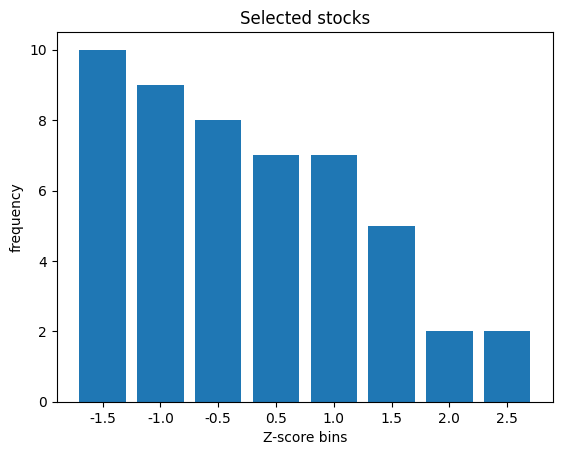

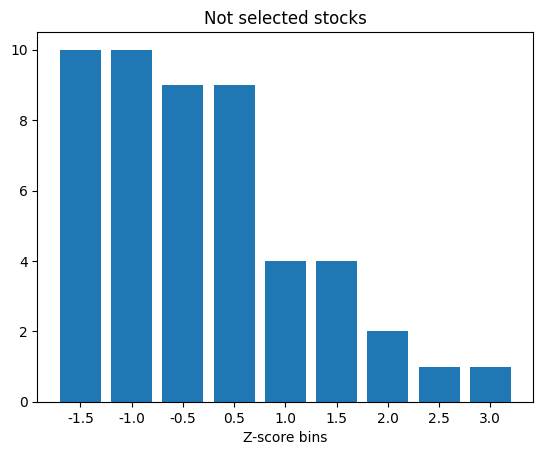

In [121]:
fig1, ax1 = plt.subplots()
print(sp500_df['z-score-bin'].value_counts())
ax1.set_title("Selected stocks")
ax1.bar(['-1.5','-1.0','-0.5','0.5','1.0','1.5','2.0','2.5'],sp500_df['z-score-bin'].value_counts(), label='Selected stocks z-score')
ax1.set_xlabel("Z-score bins")
ax1.set_ylabel("frequency")
fig2, ax2 = plt.subplots()
print(non_sp500_df['z-score-bin'].value_counts())
ax2.set_title("Not selected stocks")
ax2.bar(['-1.5','-1.0','-0.5','0.5','1.0','1.5','2.0','2.5','3.0'],non_sp500_df['z-score-bin'].value_counts(), label='Not selected stocks z-score')
ax2.set_xlabel("Z-score bins")
ax1.set_ylabel("frequency")



Conclusion 1: As there are more positive values  greater than the mean in the Selected stocks chart, the stocks we selected issued more dividends than the mean as compared to the stocks we did not select

In [122]:
# Hypothesis 2 Statement:

# The purpose of this analysis is to determine whether average dividends per share (DPS)
# have declined over time.

# Null Hypothesis (H₀): The average DPS from 2000 to 2010 is greater than or equal to the
# average DPS from 2015 to 2025.

# Alternative Hypothesis (H₁): The average DPS from 2000 to 2010 is greater than the
# average DPS from 2015 to 2025.

# We will perform a one-tailed independent two-sample T-test with a significance level of 0.05.


In [123]:
final_df['Year'] = pd.to_datetime(final_df['Start']).dt.year

In [124]:
early = final_df[(final_df['Year'] >= 2000) & (final_df['Year'] <= 2010)]['Value']
recent = final_df[(final_df['Year'] >= 2015) & (final_df['Year'] <= 2025)]['Value']
early = pd.to_numeric(early, errors='coerce').dropna().tolist()
recent = pd.to_numeric(recent, errors='coerce').dropna().tolist()

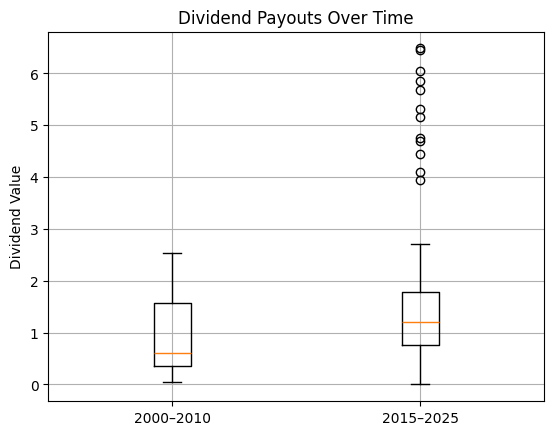

In [125]:
plt.boxplot([early, recent], tick_labels=["2000–2010", "2015–2025"])
plt.title("Dividend Payouts Over Time")
plt.ylabel("Dividend Value")
plt.grid(True)
plt.show()


In [126]:
# Run two-sample t-test
t_stat, p_val_two_tailed = ttest_ind(early, recent, equal_var=False)

# One-tailed p-value
p_val_one_tailed = p_val_two_tailed / 2

print("T-statistic:", t_stat)
print("One-tailed p-value:", p_val_one_tailed)

T-statistic: -4.083063858192542
One-tailed p-value: 3.6783380746164574e-05


In [127]:
alpha = 0.05
if p_val_one_tailed < alpha and t_stat > 0:
    print("Dividends have statistically significantly declined over time.")
else:
    print("No strong evidence of a decline in dividends.")


No strong evidence of a decline in dividends.


In [128]:
print("Mean 2000–2010:", np.mean(early))
print("Mean 2015–2025:", np.mean(recent))


Mean 2000–2010: 0.9230660377358492
Mean 2015–2025: 1.4732770949720668


In [129]:
# Conclusion 2: The dataset contains historical data on dividends per share (DPS) for various companies over time.
# To test whether average DPS has declined, we compared two periods: 2000–2010 and 2015–2025.
# Using a one-tailed independent two-sample t-test, we found that the mean DPS was actually higher in the more recent period.
# The test yielded a p-value greater than 0.05, and the direction of the difference did not support our hypothesis.
# Therefore, we fail to reject the null hypothesis and conclude that there is no strong statistical evidence
# that dividend payouts have declined over time.
# In fact, the data suggests that DPS may have slightly increased in the more recent decade.

Hypothesis 3

In [130]:
print(len(final_df))
print(len(final_df.drop_duplicates()))

290
290


So, there appear to be MANY duplicates in the data.  Let's remove all of them

In [131]:
final_df = final_df.drop_duplicates()
final_df

,Start,End,Value,Symbol,Year
0,2007-01-01,2007-12-31,1.92,MMM,2007
1,2008-01-01,2008-12-31,2,MMM,2008
2,2009-01-01,2009-12-31,2.04,MMM,2009
3,2012-01-01,2012-12-31,2.36,MMM,2012
4,2013-01-01,2013-12-31,2.54,MMM,2013
...,...,...,...,...,...
285,2020-01-01,2020-12-31,0.96,CHD,2020
286,2021-01-01,2021-12-31,1.01,CHD,2021
287,2022-01-01,2022-12-31,1.05,CHD,2022
288,2023-01-01,2023-12-31,1.09,CHD,2023


Much better! Now, let's check the distribution of years...

In [132]:
final_df['Year'] = pd.to_datetime(final_df['Start']).dt.year
#final_df['Year'].astype(str).describe()
vals = final_df['Year'].astype(str).value_counts()
vals = vals.sort_index()
vals

,count
Year,
2007,10
2008,15
2009,14
2010,14
2011,12
2012,15
2013,16
2014,15
2015,17


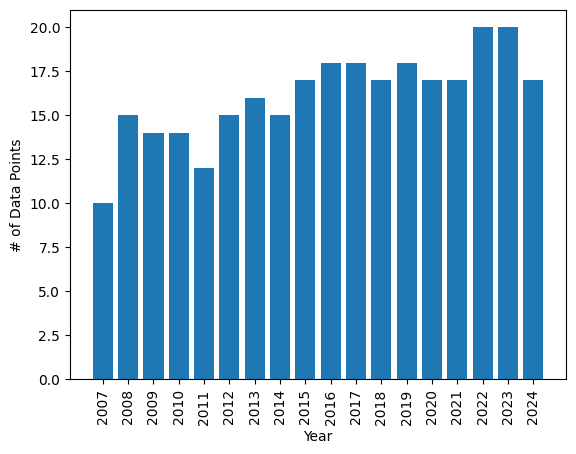

In [133]:
plt.bar(x=vals.index, height=vals.values)
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("# of Data Points")
plt.show()

There are 18 different years, with 2022 and 2015 as the most frequent, while 2007 and 2008 are the least frequent. The latter part makes sense, given that earlier on it's reasonable to expect for record-keeping to be smaller in scope. However, the number of datapoints for the more recent years appears to be mostly consistent.

Let's also analyze how many data points are there for each ticker.

In [134]:
vals = final_df["Symbol"].value_counts()
vals

,count
Symbol,
BAC,18
BK,18
LNT,17
BALL,17
CHD,17
AON,16
CF,16
AEE,15
BRO,15


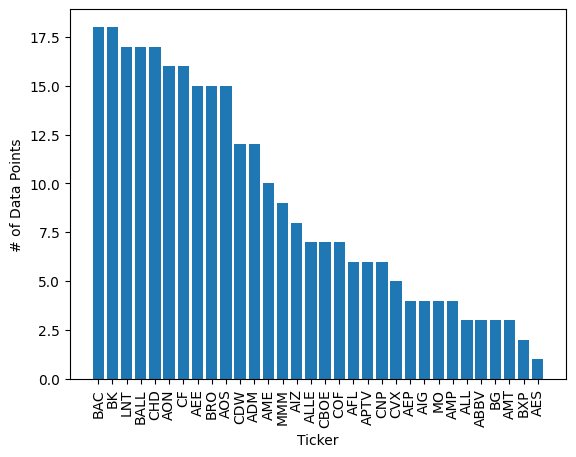

In [135]:
plt.bar(x=vals.index, height=vals.values)
plt.xticks(rotation=90)
plt.xlabel("Ticker")
plt.ylabel("# of Data Points")
plt.show()

There is a much greater spread in the amount of data points for each category when said category is tickers. "BAC" and "BK" have datapoints for all 18 years, while "AES" has only one! When it comes to the machine learning section of our project, it may be useful to take out the tickers that have less than "n" number of data points. After all, it would be rather difficult to predict based off of one time stamp!

One last thing... we want the span of time for each data point to be one fiscal year. In other words, we want the start years and the end years to be PERFECTLY correlated with each other.

In [136]:
final_df['End Year'] = pd.to_datetime(final_df['End']).dt.year
final_df[['Year', 'End Year']].corr()

,Year,End Year
Year,1.0,1.0
End Year,1.0,1.0


Conclusion 3: Ones all around. Looks like we've got nothing to worry about!

In [137]:
len(final_df) - len(final_df[["End", "Symbol"]].drop_duplicates())

0

So for each ticker, we do not have any repeat years. That's good! Now, let's move on to the next part, and start working on the machine learning part!

# **Primary Analysis**

First, let's filter our dataset for companies with 6 or more data points.

In [138]:
final_df = final_df.groupby("Symbol").filter(lambda g: len(g) > 6)

# Confirm that filtering worked
final_df["Symbol"].value_counts()

,count
Symbol,
BAC,18
BK,18
CHD,17
BALL,17
LNT,17
CF,16
AON,16
AOS,15
BRO,15


Now let's reformat the dataframe to work with our neural network.

In [139]:
Symbols = final_df["Symbol"].drop_duplicates()
val_array = []
target_vals = []

for Symbol in Symbols:
  new_array = []

  for x in range(2007, 2024):
    specifier = final_df[final_df["Symbol"] == Symbol]
    print(str(x) + "-01-01")
    specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
    if len(specifier) > 0:
      new_array.append(float(specifier["Value"].values[0]))
    else:
      new_array.append(pd.NA)

  specifier = final_df[final_df["Symbol"] == Symbol]
  specifier = specifier[final_df["Start"] == "2024-01-01"]
  if len(specifier) > 0:
    target_vals.append(float(specifier["Value"].values[0]))
  else:
    target_vals.append(pd.NA)

  val_array.append(new_array)

2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01
2021-01-01
2022-01-01
2023-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01
2021-01-01
2022-01-01
2023-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01
2021-01-01
2022-01-01
2023-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01
2021-01-01
2022-01-01
2023-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01
2021-01-01
2022-01-01
2023-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01

/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match D

2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01
2021-01-01
2022-01-01
2023-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01
2021-01-01
2022-01-01
2023-01-01


/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specifier = specifier[final_df["Start"] == str(x) + "-01-01"]
/tmp/ipython-input-139-780234685.py:11: UserWarning: Boolean Series key will be reindexed to match D

In [140]:
val_array

[[1.92,
  2.0,
  2.04,
  <NA>,
  <NA>,
  2.36,
  2.54,
  3.42,
  4.1,
  4.44,
  4.7,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>],
 [<NA>,
  <NA>,
  0.51,
  0.54,
  0.3,
  0.36,
  0.46,
  0.3,
  0.38,
  0.48,
  0.56,
  0.76,
  0.9,
  0.98,
  1.06,
  1.14,
  1.22],
 [<NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  0.84,
  1.08,
  1.28,
  1.44,
  1.64,
  1.8],
 [<NA>,
  1.4,
  1.5,
  1.58,
  1.7,
  1.8,
  1.88,
  1.02,
  1.1,
  1.175,
  1.26,
  1.34,
  1.42,
  1.52,
  1.61,
  1.71,
  1.81],
 [2.54,
  2.54,
  <NA>,
  <NA>,
  <NA>,
  1.6,
  1.6,
  1.61,
  1.655,
  1.715,
  1.7775,
  1.8475,
  1.92,
  2.0,
  2.2,
  2.36,
  2.52],
 [<NA>,
  <NA>,
  <NA>,
  0.18,
  0.16,
  0.22,
  0.24,
  0.33,
  0.36,
  0.36,
  0.36,
  0.56,
  0.56,
  <NA>,
  <NA>,
  <NA>,
  <NA>],
 [0.6,
  0.6,
  0.6,
  0.6,
  0.6,
  0.62,
  0.68,
  0.92,
  1.15,
  1.29,
  1.41,
  1.56,
  1.72,
  <NA>,
  <NA>,
  2.19,
  2.41],
 [<NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  <NA>,
  0.76,

In [141]:
target_vals

[<NA>,
 <NA>,
 1.92,
 1.92,
 2.68,
 <NA>,
 2.64,
 2.0,
 <NA>,
 0.8,
 1.0,
 1.78,
 0.54,
 <NA>,
 2.36,
 2.485,
 2.0,
 1.13]

In [142]:
neural_df = pd.DataFrame(Symbols)
neural_df = neural_df.set_index(pd.Index([y for y in range(len(Symbols))]))
print(len(val_array))
print(len(Symbols))
span = 2023 - 2007 + 1
for x in range(span):
  sprint = []
  for arr in val_array:
    sprint.append(arr[x])
  #print(sprint)
  #print(pd.Series(sprint))
  neural_df[str(x + 2007)] = pd.Series(sprint)

neural_df["2024"] = target_vals
neural_df

18
18


,Symbol,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,MMM,1.92,2.0,2.04,<NA>,<NA>,2.36,2.54,3.42,4.1,4.44,4.7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,AOS,<NA>,<NA>,0.51,0.54,0.3,0.36,0.46,0.3,0.38,0.48,0.56,0.76,0.9,0.98,1.06,1.14,1.22,<NA>
2,ALLE,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.84,1.08,1.28,1.44,1.64,1.8,1.92
3,LNT,<NA>,1.4,1.5,1.58,1.7,1.8,1.88,1.02,1.1,1.175,1.26,1.34,1.42,1.52,1.61,1.71,1.81,1.92
4,AEE,2.54,2.54,<NA>,<NA>,<NA>,1.6,1.6,1.61,1.655,1.715,1.7775,1.8475,1.92,2.0,2.2,2.36,2.52,2.68
5,AME,<NA>,<NA>,<NA>,0.18,0.16,0.22,0.24,0.33,0.36,0.36,0.36,0.56,0.56,<NA>,<NA>,<NA>,<NA>,<NA>
6,AON,0.6,0.6,0.6,0.6,0.6,0.62,0.68,0.92,1.15,1.29,1.41,1.56,1.72,<NA>,<NA>,2.19,2.41,2.64
7,ADM,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.76,0.96,1.12,1.2,1.28,1.34,1.4,1.44,1.48,1.6,1.8,2.0
8,AIZ,0.46,0.54,<NA>,<NA>,<NA>,0.81,0.96,1.06,1.37,2.03,2.15,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,BALL,<NA>,0.2,0.2,0.2,0.28,0.4,0.52,0.52,0.26,0.26,0.365,0.4,0.55,0.6,0.7,0.8,0.8,0.8


Impute NA values with the mean

In [143]:
span = 2024 - 2007 + 1
values = {}
for x in range(span):
  values[str(x + 2007)] = neural_df[str(x + 2007)].mean()

neural_df.fillna(value=values, inplace=True)

/tmp/ipython-input-143-2799183677.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  neural_df.fillna(value=values, inplace=True)


In [144]:
neural_df

,Symbol,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,MMM,1.9200,2.000000,2.040,0.43225,0.4765,2.360000,2.540000,3.420000,4.100000,4.440000,4.700000,0.9795,1.095667,1.183846,1.281538,1.481429,1.608571,1.788846
1,AOS,1.1325,1.156364,0.510,0.54000,0.3000,0.360000,0.460000,0.300000,0.380000,0.480000,0.560000,0.7600,0.900000,0.980000,1.060000,1.140000,1.220000,1.788846
2,ALLE,1.1325,1.156364,0.656,0.43225,0.4765,0.845714,0.801012,0.849273,0.970607,1.087667,1.202833,0.8400,1.080000,1.280000,1.440000,1.640000,1.800000,1.920000
3,LNT,1.1325,1.400000,1.500,1.58000,1.7000,1.800000,1.880000,1.020000,1.100000,1.175000,1.260000,1.3400,1.420000,1.520000,1.610000,1.710000,1.810000,1.920000
4,AEE,2.5400,2.540000,0.656,0.43225,0.4765,1.600000,1.600000,1.610000,1.655000,1.715000,1.777500,1.8475,1.920000,2.000000,2.200000,2.360000,2.520000,2.680000
5,AME,1.1325,1.156364,0.656,0.18000,0.1600,0.220000,0.240000,0.330000,0.360000,0.360000,0.360000,0.5600,0.560000,1.183846,1.281538,1.481429,1.608571,1.788846
6,AON,0.6000,0.600000,0.600,0.60000,0.6000,0.620000,0.680000,0.920000,1.150000,1.290000,1.410000,1.5600,1.720000,1.183846,1.281538,2.190000,2.410000,2.640000
7,ADM,1.1325,1.156364,0.656,0.43225,0.4765,0.845714,0.760000,0.960000,1.120000,1.200000,1.280000,1.3400,1.400000,1.440000,1.480000,1.600000,1.800000,2.000000
8,AIZ,0.4600,0.540000,0.656,0.43225,0.4765,0.810000,0.960000,1.060000,1.370000,2.030000,2.150000,0.9795,1.095667,1.183846,1.281538,1.481429,1.608571,1.788846
9,BALL,1.1325,0.200000,0.200,0.20000,0.2800,0.400000,0.520000,0.520000,0.260000,0.260000,0.365000,0.4000,0.550000,0.600000,0.700000,0.800000,0.800000,0.800000


For our neural network, we will have 17 input nodes. That way, we train the net on data points from 2007-2023, and test them on dividends from 2024. We believe that for 2025 predictions, we will just have to input datapoints from 2008-2024, and so on and so forth.

We will use pytorch to construct our neural network. This entails making our training and test datasets, data loaders, etcetera.

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [146]:
X = neural_df.drop(["Symbol", "2024"], axis=1)
y = neural_df["2024"]

In [147]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.166, shuffle=False)

# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test.to_numpy())

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch_size = train_loader.batch_size
num_train_data = len(train_loader) * batch_size
num_test_data = len(test_loader) * batch_size
feat_dim = train_loader.dataset[0][0].shape[0]

#Checking things...
print("Batch Size:", batch_size)
print("Number of Train Data:", num_train_data)
print("Number of Test Data:", num_test_data)
print("Feature Dimension:", feat_dim)

Batch Size: 1
Number of Train Data: 15
Number of Test Data: 3
Feature Dimension: 17


Data's been taken care of! Now let's FINALLY get around to building the model we've been hyping up for so long!

In [148]:
class DivModel(nn.Module):
    def __init__(self, feat_dim):
        super(DivModel, self).__init__()
        ### YOUR CODE HERE.
        ### 3-layer fully connected neural network.
        self.lin1 = nn.Linear(feat_dim, feat_dim//2)
        self.lin2 = nn.Linear(feat_dim//2, feat_dim//2)
        self.lin3 = nn.Linear(feat_dim//2, 1)
        self.double()

    def forward(self, x):
        ### YOUR CODE HERE.
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

model = DivModel(feat_dim=X_train.shape[1])

We use the ReLU function because sometimes the direction of dividend amounts over time may not be linear; it might dip and then rise again, for instance.

With our model defined, we now do training. This is all a very similar deal to HW #4, for the record.

In [149]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

epochs = 50
train_losses = []
test_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        model.train()
        y_pred = model(data)
        loss = criterion(y_pred, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

    #train and test losses for graphing
    test_loss = 0.0
    for batch_idx, (data, targets) in enumerate(test_loader):
        loss = criterion(model(data), targets)
        test_loss += loss.item()
    test_loss = test_loss / len(test_loader)

    test_losses.append(test_loss)

    train_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        loss = criterion(model(data), targets)
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    train_losses.append(train_loss)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

print('Finished Training')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 2.432439750345112
Epoch 2/50, Loss: 5.237219475275714
Epoch 3/50, Loss: 6.0298948416202585
Epoch 4/50, Loss: 5.363001711682988
Epoch 5/50, Loss: 2.374065836243889
Epoch 6/50, Loss: 0.344191823635805
Epoch 7/50, Loss: 2.2623273032678495
Epoch 8/50, Loss: 1.8757143200887891
Epoch 9/50, Loss: 1.6844419006429572
Epoch 10/50, Loss: 2.6120295611069895
Epoch 11/50, Loss: 1.5139885557732697
Epoch 12/50, Loss: 1.3377531116314474
Epoch 13/50, Loss: 1.6736481390367717
Epoch 14/50, Loss: 1.6182268227606684
Epoch 15/50, Loss: 1.3314616563820405
Epoch 16/50, Loss: 0.7373847916877376
Epoch 17/50, Loss: 0.4904267850945009
Epoch 18/50, Loss: 0.5550254710498709
Epoch 19/50, Loss: 0.2370677885838619
Epoch 20/50, Loss: 0.013727502707087726
Epoch 21/50, Loss: 0.08620836401190889
Epoch 22/50, Loss: 0.03293338423923735
Epoch 23/50, Loss: 0.10897511170507977
Epoch 24/50, Loss: 0.6612945104834195
Epoch 25/50, Loss: 0.05208888957669616
Epoch 26/50, Loss: 0.01883356808543752
Epoch 27/50, Loss: 

# **Visualization**

Let's visualize the progression of our losses:

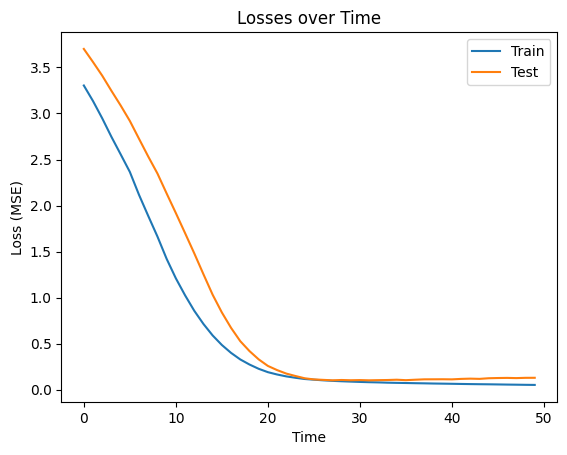

In [150]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.title("Losses over Time")
plt.xlabel("Time")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


# **Insights and Conclusions**
Our model performed fairly well, with the difference between the train and test loss decreasing as time went on.  However, the model could be improved by including more input layers that incorporate the other data available in the forms where the divided data was obtained as well as adding more stocks and their dividend data to train the model more thoroughly.